<a href="https://colab.research.google.com/github/MisaelManingo/ChemVATS/blob/main/ChemVATS_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **`ChemVATS`: Chemical Variational Autoencoder using Transformers for SELFIES**
formerly *Encoding and Decoding Molecules using Transformers*

Misael Andre D. Maningo | Dr. Miguel Francisco M Remolona

## A. Imports
Imports and installs to Google Colab.

In [1]:
!pip install selfies
import selfies as sf

!pip install rdkit
from rdkit import Chem
from rdkit.Chem import Draw, AllChem, DataStructs
from rdkit.Chem.Descriptors import MolWt
from IPython.display import Image, display

!pip install keras-nlp==0.7.0 tensorflow==2.15 tensorflow-text==2.15 --upgrade -q
from keras_nlp.layers import TransformerEncoder, TransformerDecoder, SinePositionEncoding
from keras_nlp.samplers import GreedySampler, BeamSampler, TopKSampler, TopPSampler

!pip install textdistance
import textdistance

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dropout, GlobalAveragePooling1D, Layer, Lambda, Add
from tensorflow.keras.models import Model, Sequential
from keras import backend as K
from collections import Counter
from sklearn.model_selection import train_test_split

import random
import math
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 51.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source

Output wrapping in Google Colab.

In [2]:
from IPython.display import HTML, display

#pre-wrap vs nowrap vs normal vs pre
def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## B. Database

### B.1. Sample ZINC Database (250k)

In [4]:
data_url = "https://github.com/aspuru-guzik-group/selfies/raw/16a489afa70882428bc194b2b24a2d33573f1651/examples/vae_example/datasets/dataJ_250k_rndm_zinc_drugs_clean.txt"
data_SMILES = pd.read_csv(data_url, header=None, names=['SMILES'])
print(f"Total number of molecules in imported dataset: {len(data_SMILES)}")

Total number of molecules in imported dataset: 249456


Convert from SMILES to SELFIES.

In [5]:
LOAD_FROM_FILE = True
MASTER_SELFIES_FILE_NAME = '/content/drive/MyDrive/Colab Notebooks/ChemVATS 2.0/master_SELFIES.txt'

master_SELFIES = []

if not LOAD_FROM_FILE:
    master_SELFIES = [sf.encoder(s) for s in data_SMILES.iloc[:, 0]]
    with open(MASTER_SELFIES_FILE_NAME, 'w') as file:
        for item in master_SELFIES:
            file.write(f"{item}\n")
else:
    with open(MASTER_SELFIES_FILE_NAME, 'r') as file:
        for line in file:
            master_SELFIES.append(line.strip())

max_length = max(sf.len_selfies(s) for s in master_SELFIES) + 2 #for start and end token
print(f"Maximum token length: {max_length}")

Maximum token length: 74


## C. Data Preprocessing

### C.1. SELFIES Encoding

Lists all unique symbols from master data set and makes a look-up table.

In [6]:
alphabet = sf.get_alphabet_from_selfies(master_SELFIES)
alphabet = list(sorted(alphabet))  # ['[=O]', '[C]', '[F]', '[O]', '[nop]']
alphabet.insert(0, "[nop]") # [nop] is a special padding symbol. Placed at position 0
vocab_size = len(alphabet) - 1 # 0 is not part of the vocabulary
print(f"Vocab size: {vocab_size}")

symbol_to_idx = {s: i for i, s in enumerate(alphabet)}
idx_to_symbol = {v: k for k, v in symbol_to_idx.items()}

Vocab size: 107


Converts from SELFIES to integer (label) encoding.

In [7]:
LOAD_FROM_FILE = True
MASTER_SET_FILE_NAME = '/content/drive/MyDrive/Colab Notebooks/ChemVATS 2.0/master_set.npy'

if not LOAD_FROM_FILE:
    if vocab_size > 126: print("WARNING: Use of int8 might not represent all integers.")
    master_set = np.empty((len(master_SELFIES),), dtype=np.ndarray)
    for x in range(len(master_SELFIES)):
        if x % 100_000 == 0: print(f"Processed molecules: {x}")
        master_set[x] = np.array(sf.selfies_to_encoding(
            selfies = master_SELFIES[x],
            vocab_stoi = symbol_to_idx,
            pad_to_len = max_length,
            enc_type = "label"
        )).astype(np.int8) # int8 only stores integers from -127 to 127 ONLY!!!
    master_set = np.vstack(master_set[0:len(master_set)])
    np.save(MASTER_SET_FILE_NAME, master_set)
else:
    master_set = np.load(MASTER_SET_FILE_NAME)

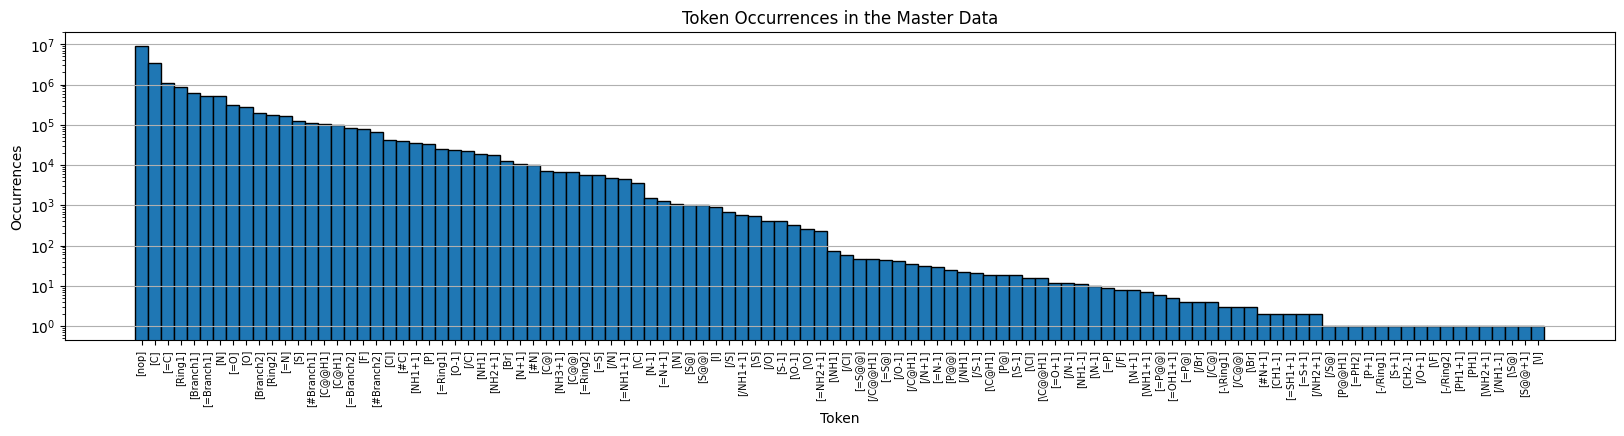

{'[nop]': 9121683, '[C]': 3533649, '[=C]': 1124766, '[Ring1]': 858769, '[Branch1]': 621084, '[=Branch1]': 523634, '[N]': 508935, '[=O]': 318170, '[O]': 279515, '[Branch2]': 202233, '[Ring2]': 177927, '[=N]': 169068, '[S]': 126694, '[#Branch1]': 110664, '[C@@H1]': 104643, '[C@H1]': 101674, '[=Branch2]': 85255, '[F]': 79421, '[#Branch2]': 66408, '[Cl]': 42797, '[#C]': 38534, '[NH1+1]': 35134, '[P]': 32584, '[=Ring1]': 25308, '[O-1]': 23916, '[/C]': 21745, '[NH1]': 18937, '[NH2+1]': 17342, '[Br]': 12715, '[N+1]': 10819, '[#N]': 10270, '[C@]': 7033, '[NH3+1]': 6788, '[C@@]': 6566, '[=Ring2]': 5738, '[=S]': 5554, '[/N]': 4849, '[=NH1+1]': 4577, '[\\C]': 3480, '[N-1]': 1475, '[=N+1]': 1279, '[\\N]': 1048, '[S@]': 1036, '[S@@]': 1008, '[I]': 887, '[/S]': 692, '[/NH1+1]': 572, '[\\S]': 555, '[/O]': 407, '[S-1]': 407, '[\\O-1]': 318, '[\\O]': 261, '[=NH2+1]': 226, '[\\NH1]': 72, '[/Cl]': 59, '[=S@@]': 47, '[/C@@H1]': 46, '[=S@]': 43, '[/O-1]': 42, '[/C@H1]': 34, '[/N+1]': 31, '[=N-1]': 30, '[P@

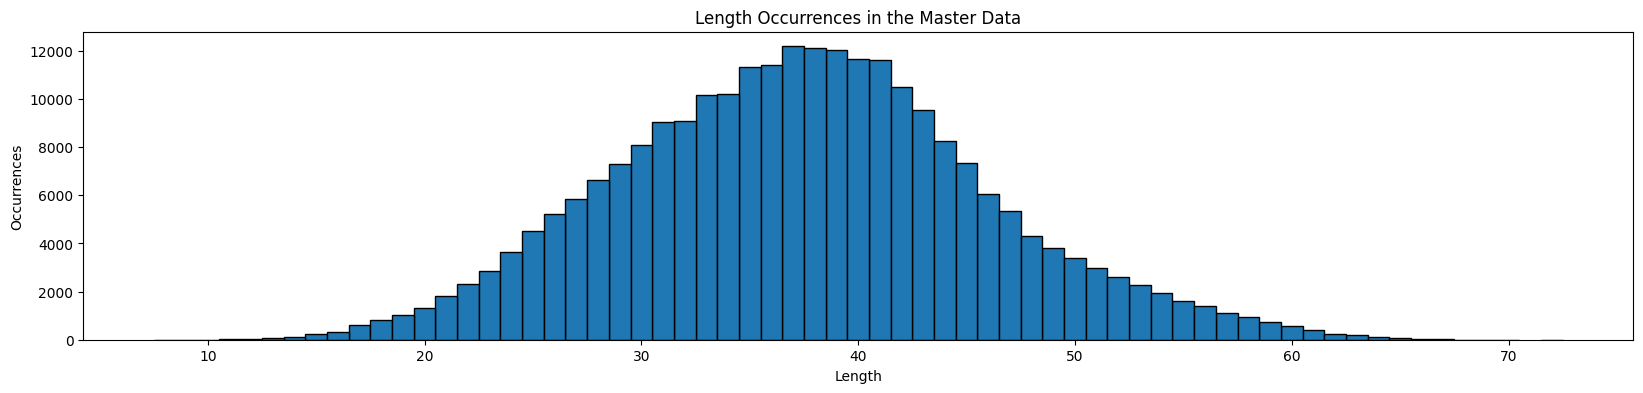

Sort based on length (ascending): {8: 3, 9: 3, 10: 5, 11: 16, 12: 20, 13: 61, 14: 118, 15: 233, 16: 308, 17: 612, 18: 824, 19: 1030, 20: 1330, 21: 1833, 22: 2316, 23: 2848, 24: 3641, 25: 4516, 26: 5213, 27: 5844, 28: 6641, 29: 7312, 30: 8071, 31: 9023, 32: 9097, 33: 10154, 34: 10197, 35: 11323, 36: 11412, 37: 12183, 38: 12115, 39: 12028, 40: 11639, 41: 11606, 42: 10495, 43: 9548, 44: 8252, 45: 7348, 46: 6054, 47: 5350, 48: 4324, 49: 3817, 50: 3393, 51: 2985, 52: 2606, 53: 2274, 54: 1934, 55: 1602, 56: 1415, 57: 1130, 58: 924, 59: 743, 60: 570, 61: 412, 62: 258, 63: 197, 64: 102, 65: 72, 66: 38, 67: 16, 68: 8, 69: 8, 70: 4, 72: 2}
Sort based on size (descending): {37: 12183, 38: 12115, 39: 12028, 40: 11639, 41: 11606, 36: 11412, 35: 11323, 42: 10495, 34: 10197, 33: 10154, 43: 9548, 32: 9097, 31: 9023, 44: 8252, 30: 8071, 45: 7348, 29: 7312, 28: 6641, 46: 6054, 27: 5844, 47: 5350, 26: 5213, 25: 4516, 48: 4324, 49: 3817, 24: 3641, 50: 3393, 51: 2985, 23: 2848, 52: 2606, 22: 2316, 53: 2274

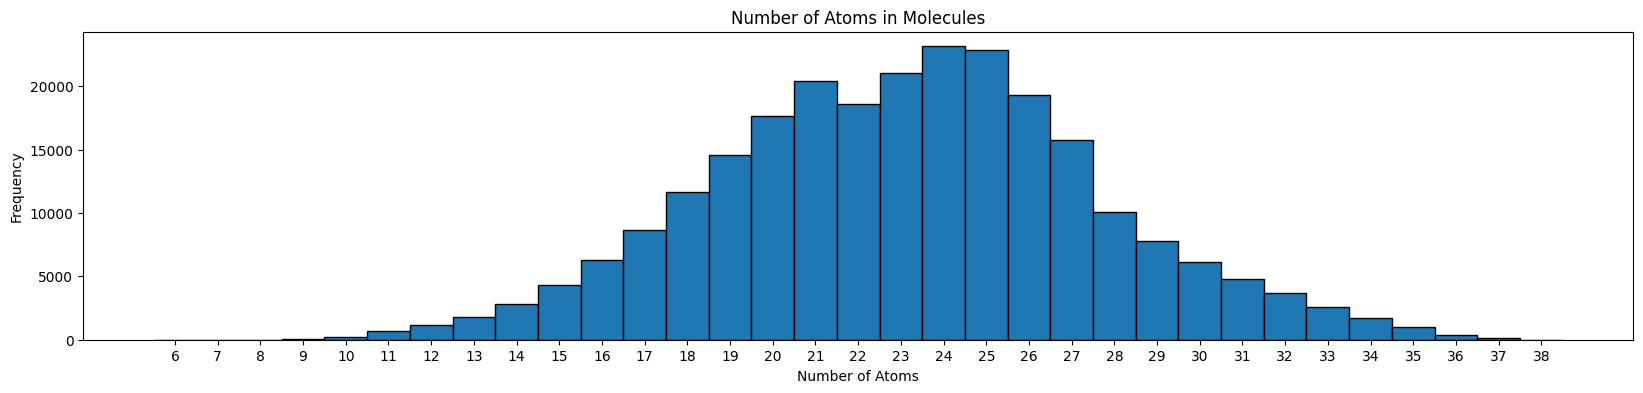

Ave: 23.151


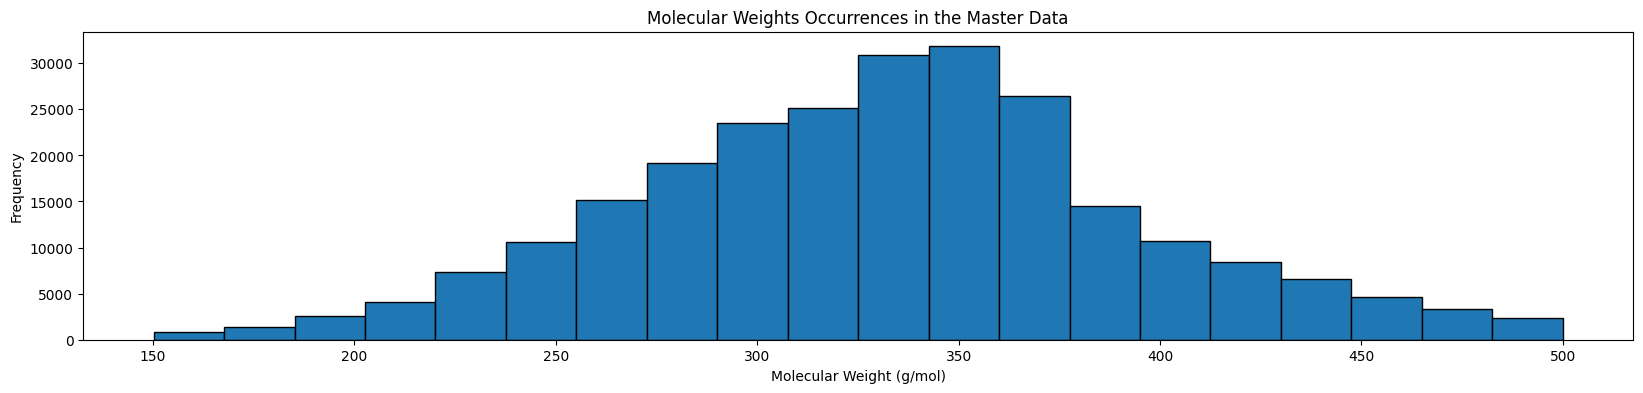

Min: 150.121 	 Ave: 332.140 	 Max: 500.000


In [ ]:
#@title Dataset Properties
from collections import Counter

# TOKEN OCCURENCES
token_counts = Counter(master_set.flatten())
numbers = list(token_counts.keys())
occurrences = list(token_counts.values())
token_counts = {idx_to_symbol[key]: value for key, value in token_counts.items()}
token_counts = {k: v for k, v in sorted(token_counts.items(), key=lambda item: item[1], reverse=True)}
categories = list(token_counts.keys())
occurrences = list(token_counts.values())

plt.figure(figsize=(20, 4))
plt.bar(categories, occurrences, align='center', edgecolor='black', width=1.0)
plt.xlabel('Token')
plt.ylabel('Occurrences')
plt.yscale('log')
plt.grid(axis = 'y')
plt.title('Token Occurrences in the Master Data')
plt.xticks(rotation=90, fontsize=7)
plt.show()
print(token_counts)

# TOKEN LENGTH OCCURENCES
length_counts = Counter([len(token)-(token == 0).sum() for token in master_set])
numbers = list(length_counts.keys())
occurrences = list(length_counts.values())

plt.figure(figsize=(20, 4))
plt.bar(numbers, occurrences, align='center', edgecolor='black', width=1.0)
plt.xlabel('Length')
plt.ylabel('Occurrences')
plt.title('Length Occurrences in the Master Data')
plt.show()
length_counts = dict(sorted(length_counts.items()))
print("Sort based on length (ascending):", length_counts)
length_counts = dict(sorted(length_counts.items(), key=lambda item: item[1], reverse=True))
print("Sort based on size (descending):", length_counts)
print(f"Mean length: {np.sum(np.multiply(numbers,occurrences)) / np.sum(occurrences)}")

# ATOM LENGTH OCCURENCES
atomLength = pd.DataFrame(
        Counter([Chem.MolFromSmiles(smiles).GetNumAtoms() for smiles in data_SMILES['SMILES']]).items(),
        columns=['Number of Atoms', 'Frequency'])
atomLength = atomLength.sort_values(by='Number of Atoms')

plt.figure(figsize=(20, 4))
plt.bar(atomLength['Number of Atoms'].astype(str), atomLength['Frequency'], edgecolor='black', width=1.0)
plt.xlabel('Number of Atoms')
plt.ylabel('Frequency')
plt.title('Number of Atoms in Molecules')
plt.show()
print(f"Ave: {(atomLength['Number of Atoms'] * atomLength['Frequency']).sum() / atomLength['Frequency'].sum():.3f}")

# MOLECULAR WEIGHTS OCCURENCES
weights = []
for smiles in data_SMILES['SMILES']:
    weights.append( MolWt(Chem.MolFromSmiles(smiles)) )

plt.figure(figsize=(20, 4))
plt.hist(weights, bins=20, edgecolor='black')
plt.xlabel('Molecular Weight (g/mol)')
plt.ylabel('Frequency')
plt.title('Molecular Weights Occurrences in the Master Data')
plt.show()
print(f"Min: {min(weights):.3f} \t Ave: {np.mean(weights):.3f} \t Max: {max(weights):.3f}")

### C.2. Data Splitting
Splits data into training/validation/test sets. Also determines length of padding needed.

In [8]:
train_set, test_set = train_test_split(master_set, test_size=0.2, random_state=42)

In [9]:
start_token = vocab_size + 2
end_token = vocab_size + 1

intType = np.int8 # for int8

def addStartToken(x):
    return np.column_stack((start_token * np.ones(x.shape[0]), x[:, :-1])).astype(intType)

def addEndToken(x):
    x = x.copy()
    for i in range(len(x)):
        row = x[i]
        if 0 in row:
            last_nonzero_index = len(row) - np.argmax(row[::-1] != 0) - 1
            x[i, last_nonzero_index + 1] = end_token
    return x.astype(intType)

train_set_encoder = addEndToken(train_set)
train_set_decoder = addStartToken(train_set)

test_set_orig = test_set.copy()
test_set = addEndToken(test_set_orig)
test_set_decoder = addStartToken(test_set_orig)

In [ ]:
# from keras_nlp.layers import StartEndPacker
# start_end_packer = StartEndPacker(
#     sequence_length=max_length, start_value=start_token, end_value=end_token,
# )
# a = start_end_packer(train_set)
# print(a[0])

tf.Tensor(
[109  61  61  72  53   2  61  61  53  61  61  53  61  61  74  61  30  61
  40  72  61  32  61  32  61  53  30  57  53  61  61  71  32  82  31   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 108], shape=(74,), dtype=int8)


## D. Building

### E.1. FULL Transformer Model

In [10]:
#@title {vertical-output: true}
### HYPERPARAMETERS -----------------
embed_dim = 64          # Embedding size for each token
transformer_blocks = 1  # no. of encoder and decoder blocks
num_heads = 8           # Number of attention heads
ff_dim = 32#embed_dim * 2  # Hidden layer size in feed forward network inside transformer
latent_dim = 8          # Dimensions of latent reperesentation
beta = 1                # KL Annealing / KL divergence influence
input_dimension = vocab_size + 2 + 1 # (2) from S and E tokens and (1) for padding
output_dimension = vocab_size + 1 + 1 #check (1) from E token only?

### SAMPLING LAYER -----------------
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], max_length, latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_var) * epsilon

### ENCODER -----------------
encoder_input = Input((max_length,), dtype='int32', name='EncoderInput')
embedding_shared = Embedding(
    input_dim=input_dimension,
    output_dim=embed_dim,
    input_length=max_length,
    trainable=True,
    mask_zero=True,
    name='TokenEmbedding',
)
x = embedding_shared(encoder_input)
pos_encoding_shared = SinePositionEncoding(name='PositionEmbedding')
x = Add(name='EmbAddPos')([x, pos_encoding_shared(x)])
for i in range(transformer_blocks):
    layer_name = f'TransformerEncoder_{i+1}'
    x = TransformerEncoder(
        intermediate_dim=ff_dim,
        num_heads=num_heads,
        dropout=0,
        name=layer_name)(x)
z_mean = Dense(latent_dim, name='DenseMean')(x)
z_log_var = Dense(latent_dim, name='DenseLogVar')(x)
z = Lambda(sampling, name='LatentDense')([z_mean, z_log_var])
encoder = Model(encoder_input, [z_mean, z_log_var, z], name="ChemVATSEncoder")

### DECODER -----------------
encoder_output = Input((max_length,latent_dim,), name='EncoderOutput')
y = Dense(embed_dim, activation='relu', name='DenseDecoderExpand')(encoder_output)
decoder_input = Input((max_length,), dtype='int32', name='DecoderInput')
x = embedding_shared(decoder_input)
x = Add(name='EmbAddPos2')([x, pos_encoding_shared(x)])
for i in range(transformer_blocks):
    layer_name = f'TransformerDecoder_{i+1}'
    x = TransformerDecoder(
        intermediate_dim=ff_dim,
        num_heads=num_heads,
        dropout=0,
        name=layer_name)(x, y)
output = Dense(output_dimension,
               activation='softmax', name='FinalDense')(x)
decoder = Model([decoder_input, encoder_output], output, name="ChemVATSDecoder")

### OVERALL ChemVATS MODEL -----------------
vae_output = decoder([decoder_input, encoder(encoder_input)[2]])
vae = Model([encoder_input, decoder_input], vae_output, name="ChemVATS")

### LOSS -----------------
reconstruction_loss = keras.losses.sparse_categorical_crossentropy(encoder_input, vae_output)
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + beta * kl_loss)
vae.add_loss(vae_loss)

vae.compile(
    optimizer = 'adam',
    metrics=['sparse_categorical_accuracy'],
)

vae.summary(
    expand_nested=True,
    layer_range=["ChemVATSEncoder", "ChemVATSDecoder"]
)

Model: "ChemVATS"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ChemVATSEncoder (Functiona  [(None, 74, 8),              29168     ['EncoderInput[0][0]']        
 l)                           (None, 74, 8),                                                      
                              (None, 74, 8)]                                                      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| EncoderInput (InputLayer)  [(None, 74)]                 0         []                           |
|                                                                                                |
| TokenEmbedding (Embedding  (None, 74, 64)               7040      ['EncoderInput[0][0]']       |
| )                                                                                        

**IMPORTANT EQUATIONS**

$\text{Total Loss} = \mathcal{L}(x,\hat{x}) + \beta \times \sum_j \text{KL} \Big(q_j(z|x) \,||\, N(0,1)\Big)$

$D_{KL}(q(z|x) || p(z)) = -\frac{1}{2} \sum_{j=1}^{d} \left( 1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2 \right)$

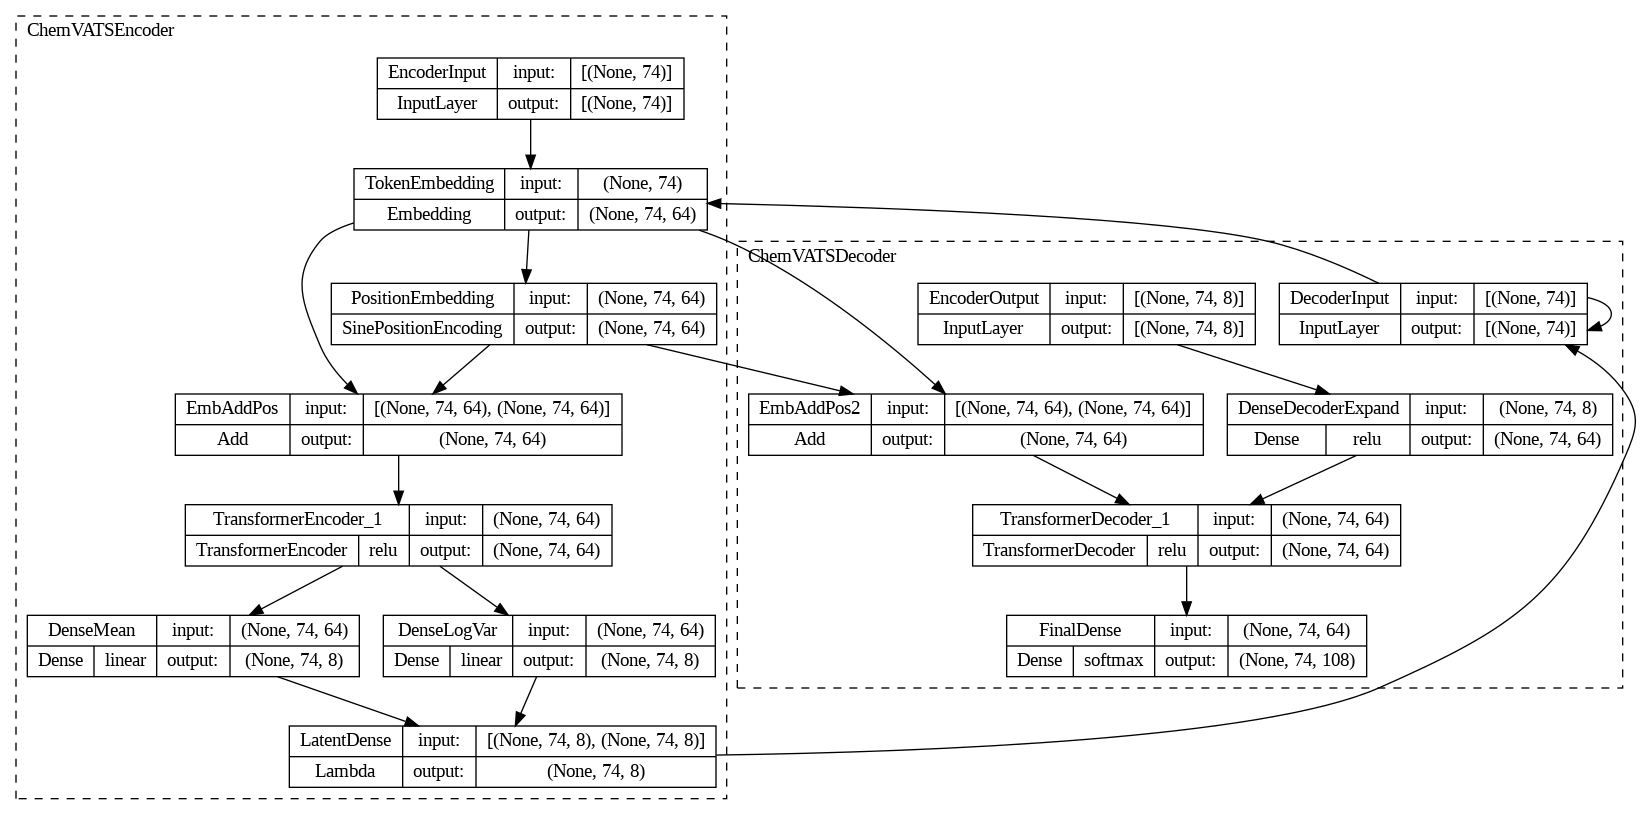

In [ ]:
#@title {vertical-output: true}
keras.utils.plot_model(
    vae,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=["ChemVATSEncoder", "ChemVATSDecoder"],
    show_layer_activations=True,
)

### E.2. Training and Testing

#### Callbacks
Checkpoint weight saving and Early Stop.

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = '/content/drive/MyDrive/Colab Notebooks/ChemVATS 2.0/weightsCheckpoint.hdf5', #weights.{epoch:02d}-{val_loss:.2f}.hdf5'
    save_weights_only = True,
    monitor = 'val_loss', #'val_sparse_categorical_accuracy'
    mode = 'min',
    save_best_only = True,
    # verbose = True,
)

early_stop = keras.callbacks.EarlyStopping(
  monitor = 'val_loss',
  mode = 'min',
  patience = 10,
  min_delta = 0.0001,
  verbose = True,
)

backup = keras.callbacks.BackupAndRestore(
    backup_dir="/content/drive/MyDrive/Colab Notebooks/ChemVATS 2.0/Backup/"
)

# %load_ext tensorboard
# tb = keras.callbacks.TensorBoard(
#     log_dir='/content/drive/MyDrive/Colab Notebooks/ChemVATS 2.0/Tensorboard/',
#     histogram_freq=0,
#     write_graph=True,
#     write_images=True,
#     write_steps_per_second=False,
#     update_freq='epoch',
#     profile_batch=0,
#     embeddings_freq=0,
#     embeddings_metadata=None,
# )

#### Fit or Loading

In [11]:
TRAIN_LOAD = "LOAD"

# TRAINING
TRAIN_SAVE = True
EPOCHS = 100
BATCH_SIZE = 128    # Change `BATCH_SIZE` CPU - 32, GPU - 128, TPU - 1024
TRAIN_WEIGHTS_FILE = "/content/drive/MyDrive/Colab Notebooks/ChemVATS 2.0/ChemVATS2.h5"

# Loading
CHECKPOINT_LOAD = True


#------------
assert TRAIN_LOAD == "TRAIN" or TRAIN_LOAD == "LOAD", "Wrong value in TRAIN_LOAD"
if TRAIN_LOAD == "TRAIN":
    print("TRAINING!")

    for i in range(len(vae.weights)):
        vae.weights[i]._handle_name = vae.weights[i].name + "_" + str(i)

    history = vae.fit(
        x = [train_set_encoder, train_set_decoder],
        y = train_set_encoder,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        shuffle = True,
        validation_split = 0.1,
        callbacks = [
            checkpoint,
            early_stop, # may be disabled to prevent premature early stop
            # backup,
            # tb, # may crash training
        ],
    )
    if TRAIN_SAVE:
        vae.save_weights(TRAIN_WEIGHTS_FILE)
        print("SAVE succesful!")
elif TRAIN_LOAD == "LOAD":
    if CHECKPOINT_LOAD:
        vae.load_weights('/content/drive/MyDrive/Colab Notebooks/ChemVATS 2.0/weightsCheckpoint.hdf5')
    else:
        vae.load_weights(TRAIN_WEIGHTS_FILE)
    print("LOAD succesful!")

LOAD succesful!


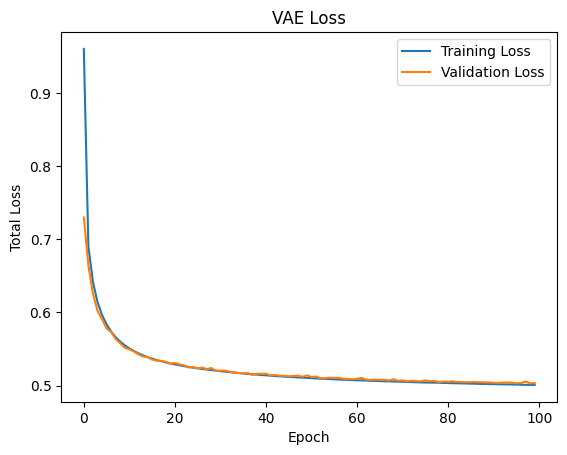

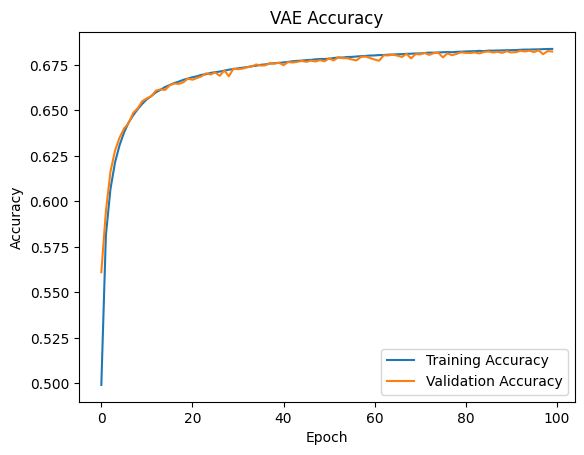

In [ ]:
#@title Learning Graphs and Tensorboard {vertical-output: true}
# Total Loss Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VAE Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

# Accuracy Plot
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('VAE Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

In [12]:
#@title Autoregressive Inference
NUM_BEAMS = 3

def encodeTransformer(input_seq):
    return encoder(np.expand_dims(input_seq,0))[2]

def decodeTransformer(encoder_output):
    def next(prompt, cache, index):
        logits = decoder([prompt, encoder_output])[:, index - 1, :]
        hidden_states = None
        return logits, hidden_states, cache

    decoded_molecule = np.zeros((1, max_length))
    decoded_molecule[0,0] = start_token

    encoder_output = tf.repeat(encoder_output, NUM_BEAMS, axis=0)
    decoded_molecule = BeamSampler(num_beams=NUM_BEAMS)( # GreedySampler, BeamSampler, TopKSampler, TopPSampler
        next = next,
        prompt = decoded_molecule,
        end_token_id = end_token,
        index = 1,
    )
    # decoded_molecule = TopPSampler(p=0.1, k=None)( # GreedySampler, BeamSampler, TopKSampler, TopPSampler
    #     next = next,
    #     prompt = decoded_molecule,
    #     end_token_id = end_token,
    #     index = 1,
    # )
    return np.array(decoded_molecule)[0][1:].astype(np.int16)

def autoencode(input_seq):
    return decodeTransformer(encodeTransformer(input_seq))

In [ ]:
%tensorboard --logdir '/content/drive/MyDrive/Colab Notebooks/Tensorboard/'

## E. Test

In [13]:
def smiles_to_encoding_test(x):
    x = sf.encoder(x)
    x = sf.selfies_to_encoding(selfies=x, vocab_stoi=symbol_to_idx, pad_to_len=max_length, enc_type="label")
    return np.expand_dims(x,0)

def remove_endToken(x):
    indexStop = np.where(x == end_token)[0]
    if len(indexStop) > 0:
        x[indexStop[0]:] = 0
    return x

def encoding_to_smiles_test(x):
    x = remove_endToken(x)
    x = sf.encoding_to_selfies(encoding=x, vocab_itos=idx_to_symbol, enc_type="label")
    x = sf.decoder(x)
    # print(x)
    return x

### Evaluate Loss and Accuracy on Test Set

In [ ]:
vae.evaluate(
    x = [test_set, test_set_decoder],
    y = test_set
)

1560/1560 [==============================] - 154s 99ms/step - loss: 0.1475 - sparse_categorical_accuracy: 0.9641


### Position Comparison

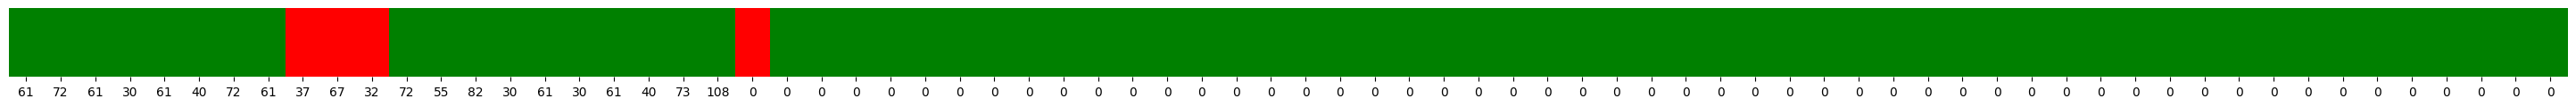

SUMMARY: 70 correct out of 74
Hamming distance: 	4
Levenshtein distance: 	4
Token similarity: 	0.9459
Cosine similarity: 	0.9595
Jaccard similarity: 	0.9221


In [20]:
#@title Position Comparison for Individual {vertical-output: true}
test = random.randint(0, len(test_set)-1)
test1 = test_set[test]
test2 = autoencode(test_set[test])

# test1 = train_set[0]
# test2 = autoencode(train_set[0])

test2 = np.pad(test2, (0, 1), constant_values= 0)

differences = np.array(test1) != np.array(test2)
heatmap_data = differences.reshape(1, -1)
plt.figure(figsize=(len(test1) // 2, 1))
sns.heatmap(heatmap_data, cmap=['green', 'red'], cbar=False, annot=False)
plt.xticks(np.arange(len(test1)) + 0.5, labels=test1)
plt.yticks([])
plt.show()

# for elem1, elem2 in zip(test1, test2):
#     if elem1 != elem2:
#         print(colored(f'Difference: {elem1} (Array 1) != {elem2} (Array 2)', 'red'))
#     else:
#         print(f'Match: {elem1} == {elem2}')

print(f"SUMMARY: {max_length - np.sum(differences)} correct out of {max_length}")
print(f"Hamming distance: \t{textdistance.hamming.distance(test1.tolist(), test2.tolist())}")
print(f"Levenshtein distance: \t{textdistance.levenshtein(test1.tolist(), test2.tolist())}")
print(f"Token similarity: \t{(max_length - np.sum(differences)) / max_length:.4f}")
print(f"Cosine similarity: \t{textdistance.cosine.similarity(test1.tolist(), test2.tolist()):.4f}")
print(f"Jaccard similarity: \t{textdistance.jaccard.similarity(test1.tolist(), test2.tolist()):.4f}")

# WORKS ON GOOGLE COLAB ONLY
for elem1, elem2 in zip(test1, test2):
    if elem1 == elem2:
        display(HTML(f"<span style='color:green'>Correct: {elem1} == {elem2}</span>"))
    else:
        display(HTML(f"<span style='color:red'>Incorrect: {elem1} != {elem2}</span>"))

    if elem1 == end_token:
        display(HTML(f"<span style='color:yellow'>-----END-----</span>"))

In [ ]:
test_i = test_set
test = sf.encoder(test_i)

Original SMILES:      CCC
Reconstructed SMILES: CCCC[CH]CC=CCCN(C)C
Tanimoto similarity: 	0.05714285714285714
Dice similarity: 	0.10810810810810811
Cosine similarity: 	0.23904572186687872
Orig.png


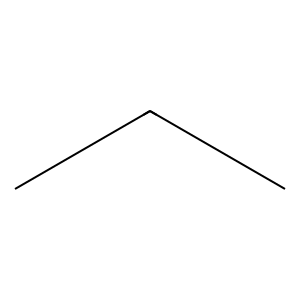

Re.png


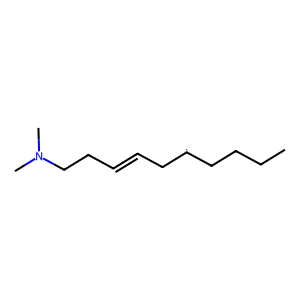

In [ ]:
#@title Latent Vector and Reconstruct Figure {vertical-output: true}
extraInfo = False
dataMode = 3 # 1 for TRAIN data, 2 for TEST data, 3 for custom

if dataMode == 1:
    test = data_SMILES.iloc[random.randint(50_000,60_000),0]
elif dataMode == 2:
    test = test_set[np.random.choice(test_set.shape[0])]
    test = encoding_to_smiles_test(test)
elif dataMode == 3:
    test = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
    test = 'FP(=O)(OC(C)C)C'
    test = 'O1C=C[C@H]([C@H]1O2)c3c2cc(OC)c4c3OC(=O)C5=C4CCC(=O)5'
    test = 'CCC'
test_i = test
if extraInfo: print("SMILES:", test)
test = sf.encoder(test)
if extraInfo: print("SELFIES", test)
test = sf.selfies_to_encoding(
        selfies = test,
        vocab_stoi = symbol_to_idx,
        pad_to_len = max_length,
        enc_type = "label"
    )
if extraInfo: print("SELFIES Encoding:", test)
latent_vector = encoder.predict(np.expand_dims(test,0),verbose=0)[2]
if extraInfo: print("Latent Vector:\n", latent_vector, "\n")
test = autoencode(test)
if extraInfo: print("Recreated Input:", test)
if extraInfo: print("Recreated Input from Latent Vector:", decodeTransformer(latent_vector))
remove_endToken(test)
test = sf.encoding_to_selfies(
    encoding = test,
    vocab_itos = idx_to_symbol,
    enc_type = "label"
)
if extraInfo: print("Reconstructed SELFIES:", test)
test = sf.decoder(test)
print("Original SMILES:     ", Chem.MolToSmiles(Chem.MolFromSmiles(test_i)))
print("Reconstructed SMILES:", Chem.MolToSmiles(Chem.MolFromSmiles(test)))

mol = [Chem.MolFromSmiles(test_i), Chem.MolFromSmiles(test)]
fpgen = AllChem.GetRDKitFPGenerator(maxPath=7, fpSize=2048)
fps = [fpgen.GetFingerprint(x) for x in mol]
print(f"Tanimoto similarity: \t{DataStructs.TanimotoSimilarity(fps[0],fps[1])}")
print(f"Dice similarity: \t{DataStructs.DiceSimilarity(fps[0],fps[1])}")
print(f"Cosine similarity: \t{DataStructs.CosineSimilarity(fps[0],fps[1])}")

Draw.MolToFile(mol[0],'Orig.png')
Draw.MolToFile(mol[1],'Re.png')

listOfImageNames = ['Orig.png',
                    'Re.png']

for imageName in listOfImageNames:
    print(imageName);display(Image(filename=imageName, width=300))

### Embedding Arithmetic

O=CNCCCCCC1CNCCCCCOCO1


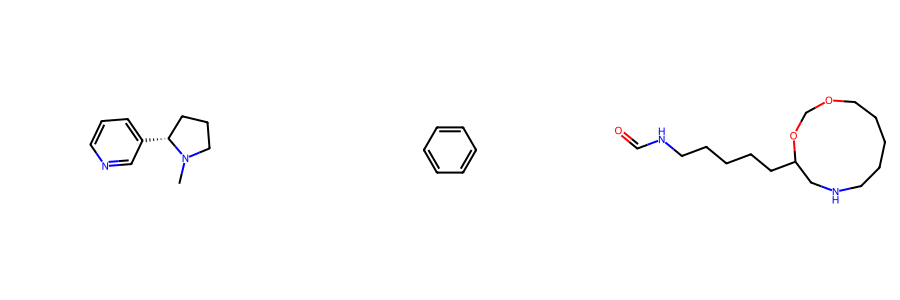

In [ ]:
test1 = "c1ncccc1[C@@H]2CCCN2C"
test2 = "c1ccccc1"

test_list = [test1, test2]
test1 = smiles_to_encoding_test(test1)
test2 = smiles_to_encoding_test(test2)

test = (encoder(test1)[2] + encoder(test2)[2]) / 2
test = decodeTransformer(test)
test = encoding_to_smiles_test(test)
test_list.append(test)
test_list = [Chem.MolFromSmiles(smiles) for smiles in test_list]
mol_matrix = [test_list[i:i + 3] for i in range(0, len(test_list), 3)]
img = Draw.MolsMatrixToGridImage(mol_matrix, subImgSize=(300, 300))
display(img)

### Interpolate

COC1=CC=C(S(=O)(=O)N(CC2=CC=CN=C2)C3=CC=C(F)C=C3)C=C1
COC1=CC=C(S(=O)(=O)N(CC2=CC=CN=C2)C3=CC=C(F)C=C3)C=C1
COC=CC1=C(C=C(O)C=C1Cl)CNC=CC(F)=C
COC=CC=C(C=C(O)C=CN(C1)CC=CC=C1C)C2NC=CC(F)=C2
COC=CC=C(C=CC(C)=C1N(C)CC=C1C=C2)CC=CC(F)=C2
CC1=CC=C(NC(=O)CC=C(C[NH1]C2=CC=CC=C2)C=CN)C=C1O
CC1=CC=C(NC(=O)CC2=CC=C(CC3=CC=CC=C3)C=C2)C=C1O
CC1=CC=C(NC(=O)C[N+1]2=CC=C(CC3=CC=CC=C3)C=C2)C=C1Cl
CC1=CC=C(NC(=O)C[N+1]2=CC=C(CC3=CC=CC=C3)C=C2)C=C1Cl


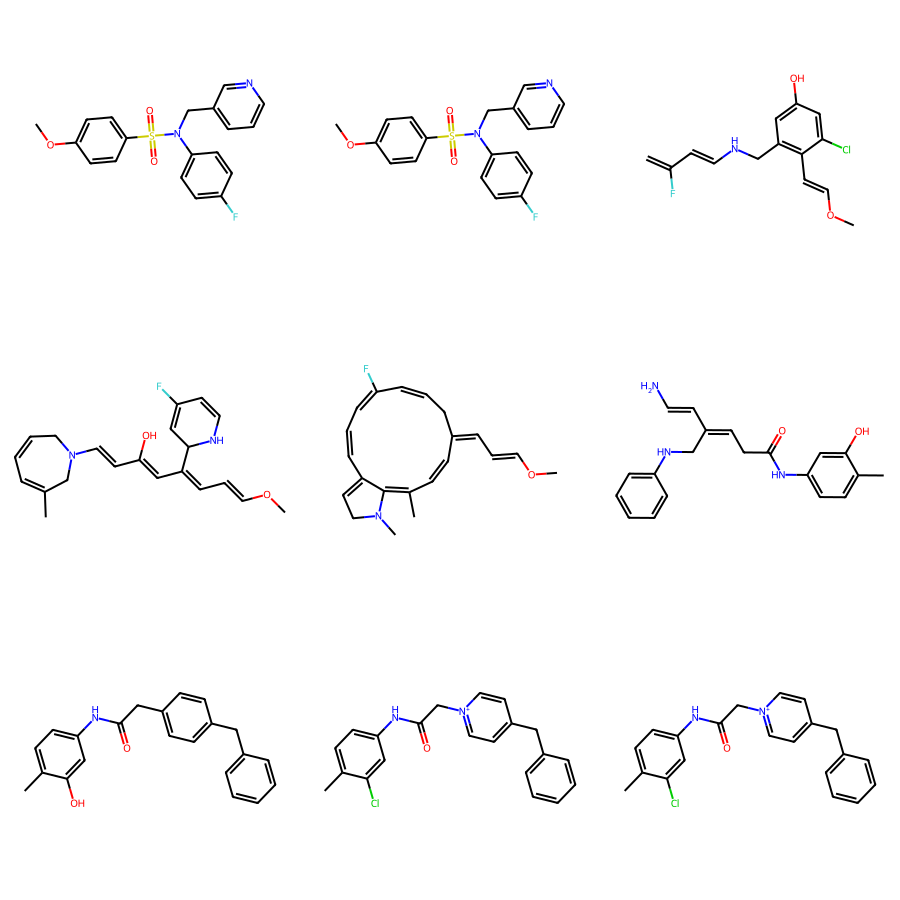

In [ ]:
#@title {vertical-output: true}
MODE = 1 # 1 for random test value, 2 for custom
num_steps = 7
COLS = 3

initial = 'O=C(Nc1ccc(OCC(O)CNC(C)C)c(c1)C(=O)C)CCC'
final = 'O=C(c1ccccc1OCC(O)CNCCC)CCc2ccccc2'

#-----------------------------------
assert MODE == 1 or MODE == 2, "Wrong value in MODE"
if MODE == 1:
    initial = [test_set[random.randint(0,len(test_set)-1)].tolist()]
    final = [test_set[random.randint(0,len(test_set)-1)].tolist()]
elif MODE == 2:
    initial = smiles_to_encoding_test(initial)
    final = smiles_to_encoding_test(final)

z1 = encodeTransformer(np.squeeze(initial))
z2 = encodeTransformer(np.squeeze(final))

interpolated_data_points = []

# LINEAR INTERPOLATION
for i in range(num_steps):
    alpha = (i + 1) / (num_steps + 1)  # Interpolation coefficient
    interpolated_latent_point = (1 - alpha) * z1 + alpha * z2
    interpolated_data_points.append(decodeTransformer(interpolated_latent_point))

# # SPHERICAL INTERPOLATION
# for i in range(num_steps):
#     alpha = (i + 1) / (num_steps + 1)  # Interpolation coefficient
#     norms1 = np.linalg.norm(z1, axis=2, keepdims=True)
#     norms2 = np.linalg.norm(z2, axis=2, keepdims=True)
#     omega = np.arccos(np.sum((z1/norms1) * (z2/norms2), axis=2))
#     coeff1 = np.sin((1 - alpha) * omega) / np.sin(omega)
#     coeff1 = np.repeat(coeff1[:, :, np.newaxis], latent_dim, axis=2)
#     coeff2 = np.sin(alpha * omega) / np.sin(omega)
#     coeff2 = np.repeat(coeff2[:, :, np.newaxis], latent_dim, axis=2)
#     interpolated_latent_point = coeff1 * z1 + coeff2 * z2
#     interpolated_data_points.append(decodeTransformer(interpolated_latent_point))

# DECODING and Graphing -----------------
test_list = []
# test = encoding_to_smiles_test(np.squeeze(decodeTransformer(z1)))
test = encoding_to_smiles_test(np.squeeze(initial))
print(test)
test_list.append(test)
for i in range(num_steps):
    test = encoding_to_smiles_test(interpolated_data_points[i])
    print(test)
    test_list.append(test)
# test = encoding_to_smiles_test(np.squeeze(decodeTransformer(z2)))
test = encoding_to_smiles_test(np.squeeze(final))
print(test)
test_list.append(test)

test_list = [Chem.MolFromSmiles(smiles) for smiles in test_list]
mol_matrix = [test_list[i:i + COLS] for i in range(0, len(test_list), COLS)]
img = Draw.MolsMatrixToGridImage(mol_matrix, subImgSize=(300, 300))
display(img)

### Graphing Latent Space

Principal Component Analysis (PCA)

1560/1560 [==============================] - 52s 33ms/step


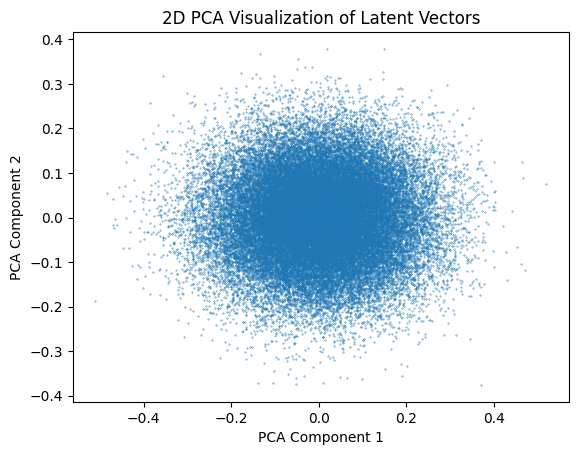

In [ ]:
#@title {vertical-output: true}
from sklearn.decomposition import PCA

latent_vectors = np.mean(encoder.predict(test_set)[2],axis=1)
# latent_vectors = encoder.predict(test_set)[2].reshape(TEST_SIZE, max_length*latent_dim)
pca = PCA(n_components=2)
latent_vectors_2d = pca.fit_transform(latent_vectors)
plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], s=0.1)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA Visualization of Latent Vectors')
plt.show()

T-distributed Stochastic Neighbor Embedding (TSNE)

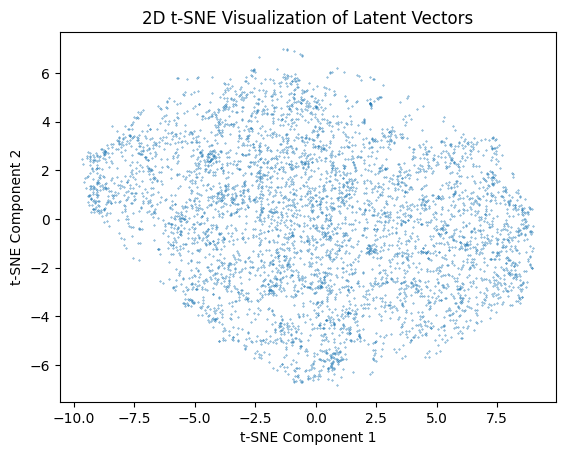

In [ ]:
#@title {vertical-output: true}
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
latent_vectors_2d_tsne = tsne.fit_transform(latent_vectors[1:5000])
plt.scatter(latent_vectors_2d_tsne[:, 0], latent_vectors_2d_tsne[:, 1], s=0.1)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('2D t-SNE Visualization of Latent Vectors')
plt.show()

### Transfer Learning
adapted from https://keras.io/examples/generative/molecule_generation/

In [ ]:
csv_path = keras.utils.get_file(
    "/content/250k_rndm_zinc_drugs_clean_3.csv",
    "https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv",
)

df = pd.read_csv("/content/250k_rndm_zinc_drugs_clean_3.csv")
df["smiles"] = df["smiles"].apply(lambda s: s.replace("\n", ""))
df.head(100)

22606589/22606589 [==============================] - 0s 0us/step


,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182
...,...,...,...,...
95,C=CCN(Cc1cccc([N+](=O)[O-])c1)C(=O)Nc1cc(OC)cc...,4.47690,0.419977,2.204004
96,Cc1cc(Cl)ccc1OCC(=O)N/N=C/c1ccccn1,2.57252,0.680288,2.075582
97,O=C1NC(=S)NC(=O)C1=CNc1ccc([N+](=O)[O-])cc1O,0.12710,0.159707,2.703933
98,Cc1c(C(=O)N2CCOCC2)oc2c1-c1nn(CC(=O)NCc3ccco3)...,1.93192,0.675385,2.845261


In [ ]:
master_df = df.sample(frac=1, random_state=42)  # random state is a seed value
master_df.reset_index(drop=True, inplace=True)

master_smiles_set, master_prop_set = [], []
for idx in range(len(master_df)):
    master_smiles_set.append(master_df.loc[idx]["smiles"])
    master_prop_set.append(master_df.loc[idx]["logP"])

master_selfies_set = [sf.encoder(s) for s in master_smiles_set]
master_encoding_set = [sf.selfies_to_encoding(
                                selfies = s,
                                vocab_stoi = symbol_to_idx,
                                pad_to_len = max_length,
                                enc_type = "label"
                            ) for s in master_selfies_set]
master_encoding_set = np.array(master_encoding_set)
master_prop_set = np.array(master_prop_set)

test = math.floor(0.8*len(master_encoding_set))
train_encoding_set = master_encoding_set[0:test]
train_prop_set = master_prop_set[0:test]
test_encoding_set = master_encoding_set[test+1:len(master_encoding_set)]
test_prop_set = master_prop_set[test+1:len(master_prop_set)]

Model: "TestNeuralNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 TestInput (InputLayer)      [(None, 72)]              0         
                                                                 
 TokenEmbedding (Embedding)  (None, 72, 64)            7104      
                                                                 
 DenseExpand (Dense)         (None, 72, 64)            4160      
                                                                 
 DenseExpand2 (Dense)        (None, 72, 108)           7020      
                                                                 
 DenseExpand3 (Dense)        (None, 72, 108)           11772     
                                                                 
 GlobalAveragePooling1D (Gl  (None, 108)               0         
 obalAveragePooling1D)                                           
                                                 

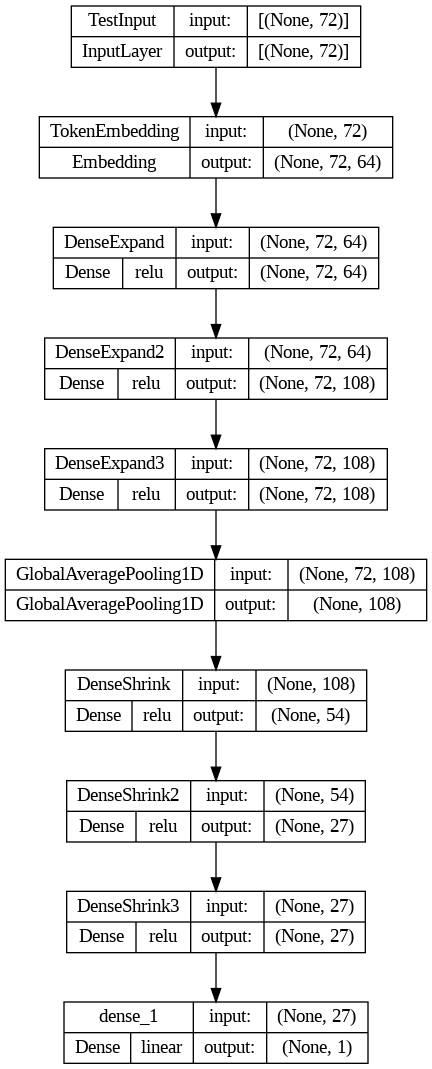

In [ ]:
#@title {vertical-output: true}
testNN_input = Input((max_length,), dtype='int32', name='TestInput')
x = Embedding(
    input_dim=vocab_size+2+1,
    output_dim=embed_dim,
    input_length=max_length,
    trainable=True,
    mask_zero=True,
    name='TokenEmbedding',
)(testNN_input)
x = Dense(64, activation='relu', name="DenseExpand")(x)
x = Dense(vocab_size, activation='relu', name="DenseExpand2")(x)
x = Dense(vocab_size, activation='relu', name="DenseExpand3")(x)
x = GlobalAveragePooling1D(name="GlobalAveragePooling1D")(x)
x = Dense(vocab_size/2, activation='relu', name="DenseShrink")(x)
x = Dense(vocab_size/4, activation='relu', name="DenseShrink2")(x)
x = Dense(vocab_size/4, activation='relu', name="DenseShrink3")(x)
testNN_output = Dense(1, activation='linear')(x)

testNN = Model(testNN_input, testNN_output, name="TestNeuralNetwork")
testNN.compile(optimizer = "adam", loss = 'mse')
testNN.summary()

keras.utils.plot_model(
    testNN,
    to_file="modelTestNN.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    # expand_nested=True,
    dpi=96,
    show_layer_activations=True,
)

Model: "TestNeuralNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 TestInput (InputLayer)      [(None, 72)]              0         
                                                                 
 ChemVATSEncoder (Functiona  [(None, 72, 8),           29232     
 l)                           (None, 72, 8),                     
                              (None, 72, 8)]                     
                                                                 
 DenseExpand (Dense)         (None, 72, 64)            576       
                                                                 
 DenseExpand2 (Dense)        (None, 72, 108)           7020      
                                                                 
 DenseExpand3 (Dense)        (None, 72, 108)           11772     
                                                                 
 GlobalAveragePooling1D (Gl  (None, 108)         

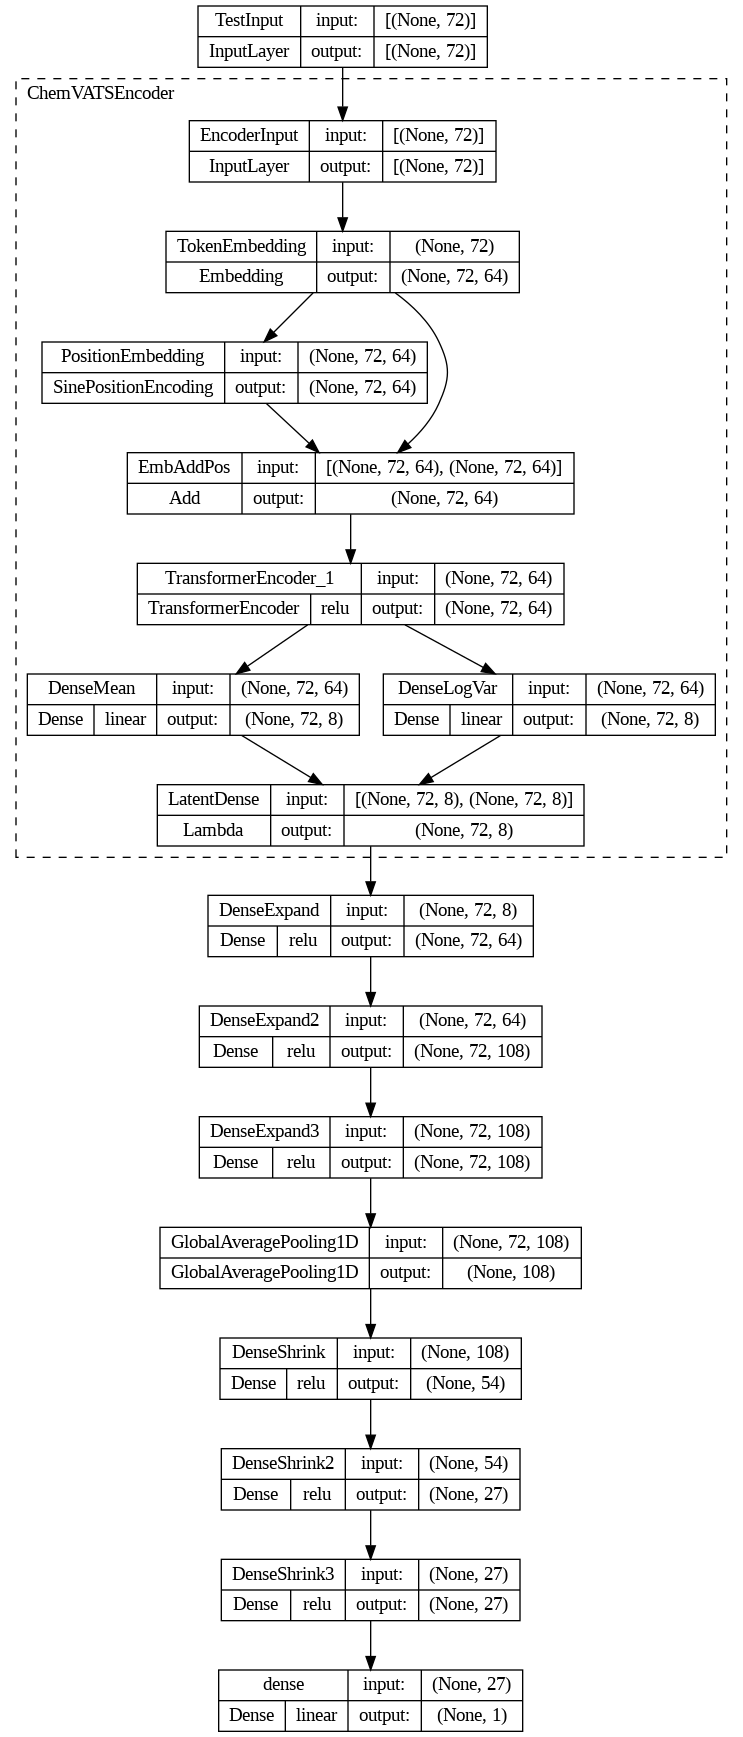

In [ ]:
#@title {vertical-output: true}
testNN_input = Input((max_length,), dtype='int32', name='TestInput')
x = encoder(testNN_input)[2]; encoder.trainable = False
x = Dense(64, activation='relu', name="DenseExpand")(x)
x = Dense(vocab_size, activation='relu', name="DenseExpand2")(x)
x = Dense(vocab_size, activation='relu', name="DenseExpand3")(x)
x = GlobalAveragePooling1D(name="GlobalAveragePooling1D")(x)
x = Dense(vocab_size/2, activation='relu', name="DenseShrink")(x)
x = Dense(vocab_size/4, activation='relu', name="DenseShrink2")(x)
x = Dense(vocab_size/4, activation='relu', name="DenseShrink3")(x)
testNN_output = Dense(1, activation='linear')(x)

testNN = Model(testNN_input, testNN_output, name="TestNeuralNetwork")
testNN.compile(optimizer = "adam", loss = 'mse')
testNN.summary()

keras.utils.plot_model(
    testNN,
    to_file="modelTestNN.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    # expand_nested=True,
    dpi=96,
    show_layer_activations=True,
)

In [ ]:
for i in range(len(testNN.weights)):
    testNN.weights[i]._handle_name = testNN.weights[i].name + "_" + str(i)

test_history = testNN.fit(
    x = train_encoding_set,
    y = train_prop_set,
    epochs = 200,
    batch_size = 64,
    shuffle = True,
    validation_split = 0.1,
)

Epoch 1/200
2807/2807 [==============================] - 36s 12ms/step - loss: 0.7317 - val_loss: 0.6368
Epoch 2/200
2807/2807 [==============================] - 26s 9ms/step - loss: 0.5503 - val_loss: 0.5833
Epoch 3/200
2807/2807 [==============================] - 18s 7ms/step - loss: 0.5416 - val_loss: 0.5452
Epoch 4/200
2807/2807 [==============================] - 19s 7ms/step - loss: 0.5421 - val_loss: 0.5921
Epoch 5/200
2807/2807 [==============================] - 19s 7ms/step - loss: 0.5377 - val_loss: 0.5283
Epoch 6/200
2807/2807 [==============================] - 19s 7ms/step - loss: 0.5326 - val_loss: 0.5444
Epoch 7/200
2807/2807 [==============================] - 19s 7ms/step - loss: 0.5268 - val_loss: 0.5173
Epoch 8/200
2807/2807 [==============================] - 18s 6ms/step - loss: 0.5197 - val_loss: 0.5302
Epoch 9/200
2807/2807 [==============================] - 20s 7ms/step - loss: 0.5079 - val_loss: 0.4991
Epoch 10/200
2807/2807 [==============================] - 18s 7

In [ ]:
# testNN.save_weights("/content/drive/MyDrive/Colab Notebooks/Models/TestNN_logP_weights.h5")
testNN.save_weights("/content/drive/MyDrive/Colab Notebooks/Models/TestNN_logP_weights_NOTRANSFORMER.h5")

In [ ]:
test = random.randint(0,10_000)
print(master_smiles_set[test])
print("Actual:     ", master_prop_set[test], "\nPrediction: ", testNN.predict(np.expand_dims(master_encoding_set[test],0), verbose=0)[0,0])

COc1ccc(NC(=O)Cc2nc3nc(C)c(Cl)c(C)n3n2)c(OC)c1
Actual:      2.59294 
Prediction:  3.165212


1560/1560 [==============================] - 4s 3ms/step


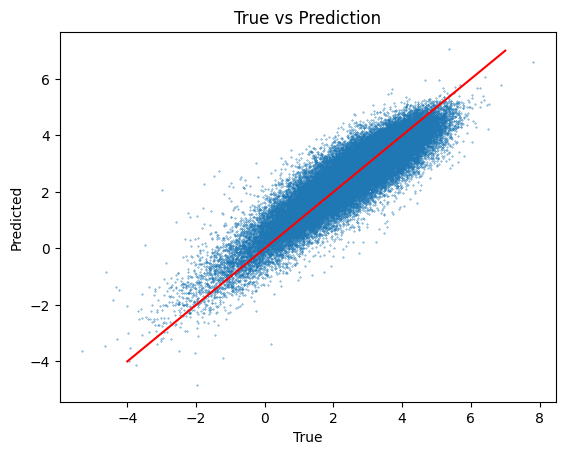

In [ ]:
#@title {vertical-output: true}
test = testNN.predict(test_encoding_set)
plt.scatter(test_prop_set, test, s=0.1)
plt.plot(np.array([-4,7]), np.array([-4,7]), label='y = x', color='red')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('True vs Prediction')
plt.show()

In [ ]:
print(f'RMSE = {math.sqrt(testNN.evaluate(test_encoding_set,test_prop_set))}')

1560/1560 [==============================] - 5s 3ms/step - loss: 0.3722
RMSE = 0.6100519039788106


# OTHERS